# User and Network Analysis
The purpose of this notebook is to analyse user behaviour and network characteristics.

## Structure
1. User Analysis
    1. Number of unique users
    2. Most active users
    3. Distribution of user activity
    4. Temporal patterns in user activity (e.g., daily/weekly trends)
    5. Identification of outlier users
2. Network Analysis
    1. Network density and sparsity
    2. Community detection using Louvain algorithm
    3. Centrality measures (e.g., degree, betweenness, closeness)
    4. Identification of key users (bridges, hubs, and influencers)
    5. Clustering coefficients and neighborhood connectivity

## Summarized Results
- The network is globally sparse, with low average clustering, meaning most users are not well-connected to their neighbors.
- Within this sparse structure, some communities form tightly-knit clusters, which the Louvain algorithm identifies.
- Central users, such as `1010626427`, act as bridges connecting these otherwise independent communities, creating a sparse but connected global network.
- User activity distribution is highly skewed, with a few users contributing disproportionately to the total activity.

In [78]:
from scripts.preprocess_data import *
# Load, clean and normalize the df
df = load_data()
df = clean_data(df)
df = normalize_data(df)

### User Analysis

##### Number of unique users

In [79]:
# Calculate the number of unique users
unique_users = df['user_id'].nunique()
print(f"Number of unique users: {unique_users}")

Number of unique users: 46755


##### Most active users

In [4]:
# Identify users with the highest activity
user_activity = df.groupby('user_id').size().reset_index(name='post_count')
top_users = user_activity.sort_values(by='post_count', ascending=False).head(10)
print("Top 10 users with the highest activity:")
print(top_users)

Top 10 users with the highest activity:
          user_id  post_count
4977   1010626427         837
36375  1077881120         178
3600   1007690223         134
14652  1031499948         123
25885  1055454345         116
22969  1049151527         102
38140  1081539622          91
31734  1068051022          86
10609  1022561255          76
3568   1007621559          75


In [34]:
top_user_id = top_users.iloc[0]["user_id"]
top_username = df.loc[df['user_id'] == top_user_id, 'user'].values[0]
print(f"The most active user is {top_username} ({top_user_id})")

The most active user is robert78 (1010626427)


- User `1010626427` (username "robert78") is an outlier with **$837$ posts**, far exceeding the next most active user with $178$ posts, emphasizing their disproportionate activity.

Analsye: what kind of posts does this guy have

# Network Analysis

In [4]:
import networkx as nx

# Load the graph data
graph_data = pd.read_csv("./data/graph.csv")

# Create an undirected graph using the source and target columns
G = nx.from_pandas_edgelist(graph_data, source='source', target='target')

##### Degree Centrality

Degree centrality quantifies the proportion of users a given user is directly connected to, representing their level of **direct influence or reach** in the network.

In social media analysis, users with high degree centrality are **key influencers or hubs** who can quickly disseminate information to many others, making them critical in campaigns, trends, or spreading information.

count    46849.000000
mean         0.000086
std          0.000195
min          0.000021
25%          0.000043
50%          0.000064
75%          0.000085
max          0.038145
dtype: float64


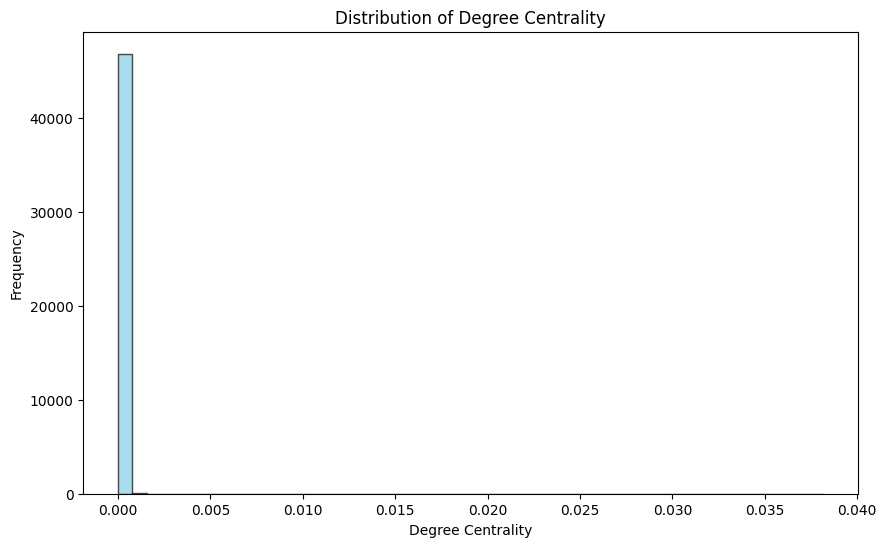

In [11]:
# calculate degree centrality for all users
degree_centrality = nx.degree_centrality(G)
# analyze the distribution of degree centrality
centrality_scores = pd.Series(degree_centrality.values())
print(centrality_scores.describe())

plt.figure(figsize=(10, 6))
plt.hist(centrality_scores, bvins=50, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("Frequency")
plt.show()

In [12]:
avg_degree_centrality = centrality_scores.mean()
print(f"Average Degree Centrality: {avg_degree_centrality}")

Average Degree Centrality: 8.64632588340147e-05


Idea: 
- find out hubs
- are spam accounts less connected (lower degree centrality)

- The network is highly sparse, as the degree centrality distribution shows that most users have extremely low centrality scores (close to 0), with only a few users acting as hubs, indicated by the maximum centrality of 0.0381.
- This sparsity could be because the data basis could be incomplete: It could be a cutout of the complete data by limiting the data export to a specific region for instance.

In [6]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
top_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 users by degree centrality:")
for user, centrality in top_degree_centrality:
    print(f"User: {user}, Centrality: {centrality}")

Top 10 users by degree centrality:
User: 1010626427, Centrality: 0.038144637978142076
User: 1027710225, Centrality: 0.001131318306010929
User: 1018042330, Centrality: 0.0010459357923497269
User: 1030048137, Centrality: 0.0010459357923497269
User: 1084949174, Centrality: 0.0009818989071038251
User: 1066276793, Centrality: 0.0009818989071038251
User: 1090990902, Centrality: 0.0009818989071038251
User: 1059101695, Centrality: 0.0009818989071038251
User: 1047703640, Centrality: 0.0009605532786885246
User: 1004360689, Centrality: 0.0009178620218579235


- User `1010626427` stands out as a major hub, being directly connected (friends) to approximately $3.81\%$ of all users, while the rest of the top 10 users have significantly lower centrality, indicating a highly uneven distribution of connections.

##### Clustering Coefficients

The clustering coefficient measures the likelihood that a user's connections (friends or followers) are also connected to one another, highlighting the local interconnectedness or "tight-knit" groups in the network.

Significance: A high clustering coefficient in social media networks indicates the presence of communities or echo chambers, where users are part of closely-knit groups, fostering information flow or reinforcing specific opinions within those groups.

In [ ]:
# Calculate clustering coefficients
clustering_coefficients = nx.clustering(G)
avg_clustering_coefficient = sum(clustering_coefficients.values()) / len(clustering_coefficients)
print(f"Average clustering coefficient: {avg_clustering_coefficient}")

Average clustering coefficient: 0.10242240045186507


 - On average, about $10.24\%$ of a user's neighbors are also connected to each other, suggesting that the network exhibits a relatively low level of local connectivity or clustering.

##### Visualize the User Connections

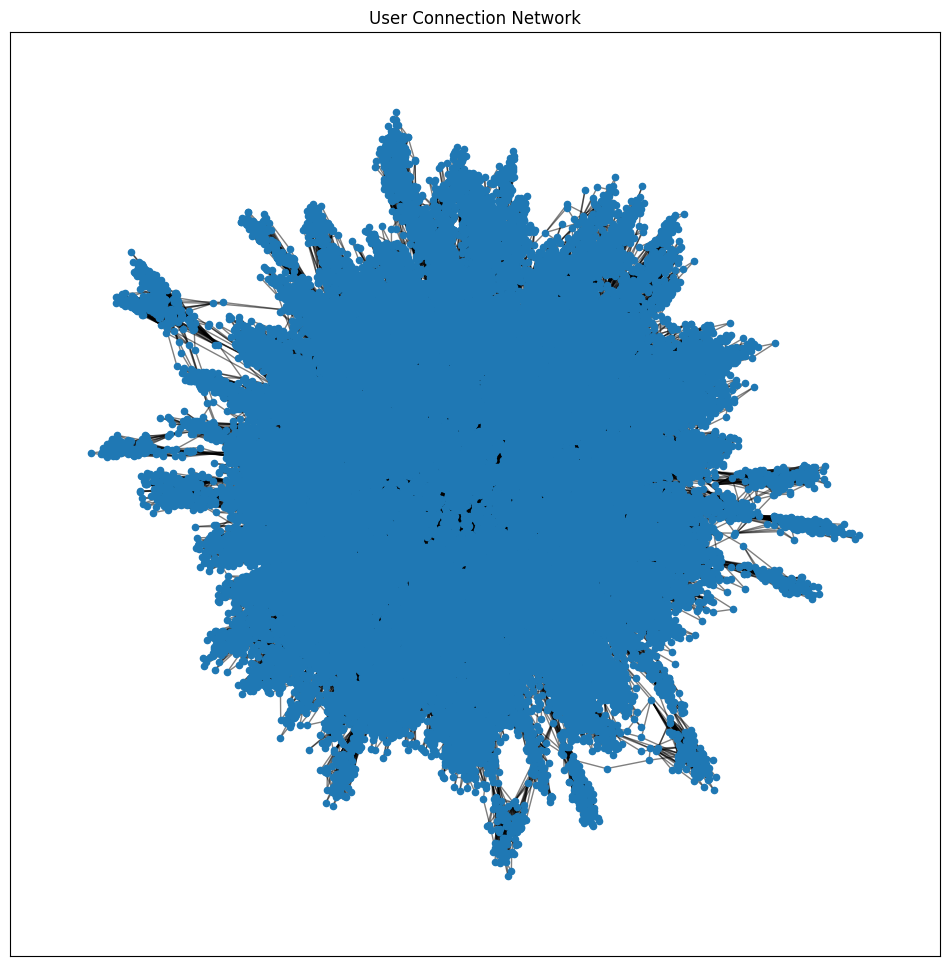

In [12]:
import matplotlib.pyplot as plt

# Visualize the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Positions for nodes
# nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("User Connection Network")
plt.show()

#### Closeness and Betweenness Centrality

Closeness centrality measures how quickly a user can reach all other users in the network, based on the shortest paths from that user to others.

Significance: In social media analysis, users with high closeness centrality can efficiently spread information or ideas, making them influential in rapidly propagating trends or news.


Betweenness centrality quantifies how often a user acts as a bridge between other users, based on the shortest paths passing through them.

Significance: Users with high betweenness centrality are critical intermediaries in the network, enabling the flow of information between otherwise disconnected groups and often acting as gatekeepers or brokers.

In [13]:
# Closeness centrality
closeness_centrality = nx.closeness_centrality(G)
top_closeness = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 users by closeness centrality:")
for user, centrality in top_closeness:
    print(f"User: {user}, Centrality: {centrality}")

# Betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 users by betweenness centrality:")
for user, centrality in top_betweenness:
    print(f"User: {user}, Centrality: {centrality}")


Top 10 users by closeness centrality:
User: 1010626427, Centrality: 0.30633022303884705
User: 1077997466, Centrality: 0.2364615563216418
User: 1021402235, Centrality: 0.2362290485891204
User: 1028635896, Centrality: 0.23563377377186057
User: 1043529958, Centrality: 0.23560296314177517
User: 1089906253, Centrality: 0.23549163805626908
User: 1001396520, Centrality: 0.23531420936575467
User: 1076700886, Centrality: 0.23517600048191803
User: 1032319872, Centrality: 0.23507569409249884
User: 1032811749, Centrality: 0.23505918124664454

Top 10 users by betweenness centrality:
User: 1010626427, Centrality: 0.9896298288685079
User: 1038230812, Centrality: 0.0070046515806957525
User: 1077997466, Centrality: 0.006013904448260786
User: 1019871970, Centrality: 0.005927335450255653
User: 1032319872, Centrality: 0.005910679364671109
User: 1075438118, Centrality: 0.005775643947694998
User: 1001396520, Centrality: 0.005432906779826888
User: 1037467053, Centrality: 0.005375260064014553
User: 104697458

- User `1010626427` is the most central in the network, with the highest closeness centrality ($0.3063$) for efficiently reaching others and an overwhelmingly high betweenness centrality ($0.9896$), indicating a critical role as a bridge connecting otherwise separate groups.

##### Community Detection

Community detection identifies clusters or groups of users in a network who are more densely connected to each other than to the rest of the network.

Significance: Understanding communities in social media helps uncover shared interests, influence patterns, and subgroups, which is useful for targeted marketing, detecting echo chambers, or analyzing group dynamics.

In [ ]:
from community import community_louvain

# Louvain community detection
partition = community_louvain.best_partition(G)
print(f"Detected communities: {len(set(partition.values()))}")

# Add nodes to communities
for node, community in partition.items():
    G.nodes[node]['community'] = community

Detected communities: 248


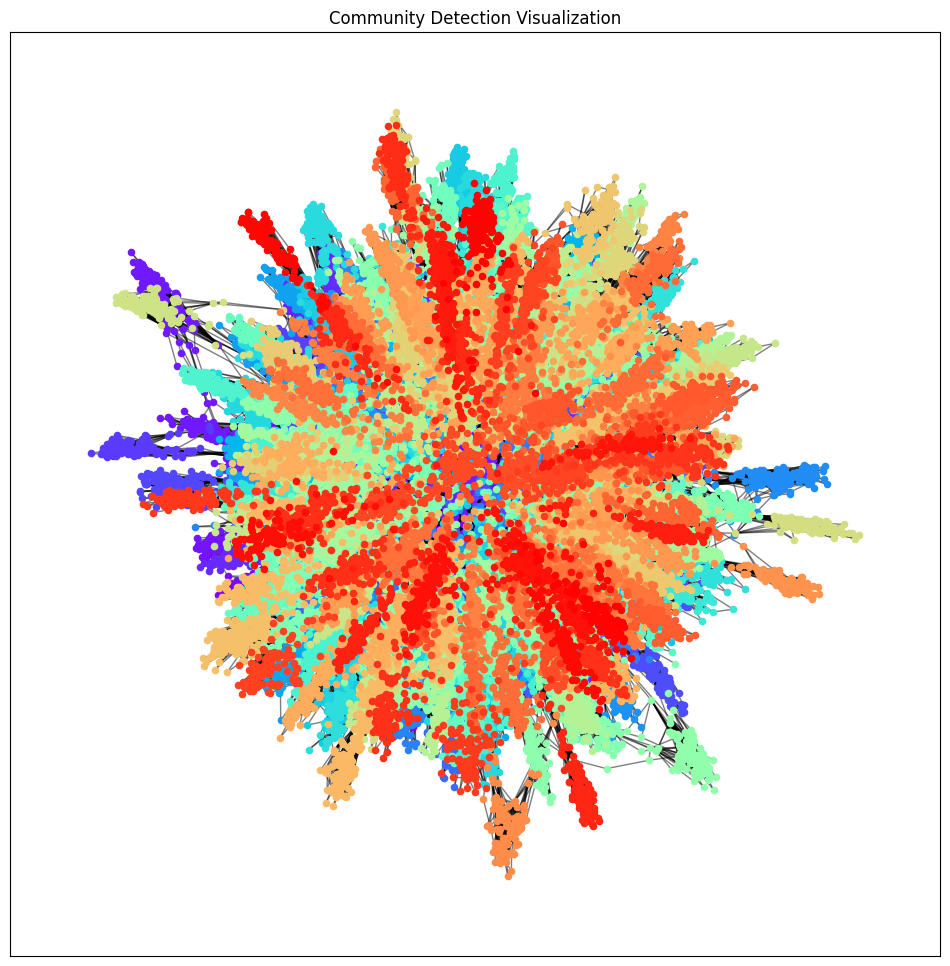

In [9]:
# Visualize communities
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)
communities = set(partition.values())
colors = plt.cm.rainbow([i / len(communities) for i in range(len(communities))])

for community, color in zip(communities, colors):
    nx.draw_networkx_nodes(
        G, pos, nodelist=[node for node in partition if partition[node] == community],
        node_size=20, node_color=[color]
    )
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Community Detection Visualization")
plt.show()

- The Louvain community detection identified $248$ distinct communities, where users within each community are more densely connected to each other than to users outside, revealing tightly-knit social groups or sub-networks.

idea: check if duplicates are in the same community

In [10]:
from collections import Counter
# Community Size
community_sizes = Counter(partition.values())
print("Community Sizes:", community_sizes)

# Density
for community in communities:
    nodes_in_community = [node for node in partition if partition[node] == community]
    subgraph = G.subgraph(nodes_in_community)
    density = nx.density(subgraph)
    print(f"Density of Community {community}: {density}")
# Modularity
modularity = community_louvain.modularity(partition, G)
print("Modularity of the partition:", modularity)

# Key Nodes (Centrality Measures)
for community in communities:
    nodes_in_community = [node for node in partition if partition[node] == community]
    subgraph = G.subgraph(nodes_in_community)
    centrality = nx.degree_centrality(subgraph)
    top_central_node = max(centrality, key=centrality.get)
    print(f"Top central node in Community {community}: {top_central_node}")

# Bridging Nodes
betweenness = nx.betweenness_centrality(G)
bridging_nodes = {node: comm for node, comm in partition.items() if betweenness[node] > 0.05}
print("Bridging Nodes:", bridging_nodes)

Community Sizes: Counter({3: 517, 9: 497, 4: 420, 58: 305, 73: 296, 45: 291, 57: 290, 8: 288, 111: 288, 167: 287, 180: 287, 134: 285, 247: 285, 41: 285, 212: 283, 79: 283, 188: 282, 213: 282, 154: 281, 193: 281, 91: 280, 70: 279, 113: 279, 15: 278, 233: 277, 178: 276, 216: 276, 85: 276, 50: 276, 78: 275, 243: 275, 96: 274, 30: 273, 38: 273, 0: 272, 131: 272, 135: 270, 214: 270, 208: 270, 191: 269, 149: 269, 129: 269, 145: 269, 170: 269, 43: 267, 83: 267, 51: 266, 197: 266, 21: 265, 71: 265, 80: 265, 189: 265, 112: 264, 195: 264, 186: 264, 74: 264, 130: 264, 117: 264, 132: 263, 142: 263, 99: 262, 124: 262, 232: 262, 211: 261, 207: 261, 22: 259, 44: 259, 121: 259, 226: 259, 220: 258, 75: 258, 110: 257, 235: 255, 127: 255, 81: 255, 126: 254, 181: 253, 42: 252, 123: 252, 223: 252, 10: 251, 133: 251, 143: 251, 183: 251, 152: 249, 87: 249, 138: 248, 157: 246, 229: 246, 184: 246, 92: 244, 166: 244, 101: 244, 137: 242, 40: 239, 60: 238, 82: 225, 194: 222, 49: 220, 34: 160, 100: 160, 69: 160, 5

In [11]:
# Step 1: Find the User's Community
user_id = 1010626427

# Get the user's community
user_community = partition.get(user_id, None)

if user_community is not None:
    print(f"User {user_id} belongs to community {user_community}.")
else:
    print(f"User {user_id} is not in the graph.")


User 1010626427 belongs to community 3.


In [12]:
# Step 2: Analyze the Community Characteristics
# 2.1 Community Size
# Nodes in the same community
community_nodes = [node for node, comm in partition.items() if comm == user_community]
print(f"Community {user_community} has {len(community_nodes)} nodes.")

# 2.2 Degree Centrality
# Subgraph of the community
subgraph = G.subgraph(community_nodes)

# Degree centrality for the community
degree_centrality = nx.degree_centrality(subgraph)
user_centrality = degree_centrality.get(user_id, 0)

# Compare user centrality to community centrality
average_centrality = sum(degree_centrality.values()) / len(degree_centrality)
print(f"User's degree centrality: {user_centrality}")
print(f"Average degree centrality in community: {average_centrality}")
if user_centrality > average_centrality:
    print(f"User {user_id} is more central than typical for community {user_community}.")
else:
    print(f"User {user_id} is less central than typical for community {user_community}.")

# 2.3 Node Features from df
# Filter `df` for users in the same community
community_df = df[df['user_id'].isin(community_nodes)]

# Compare features (e.g., post frequency)
user_features = df[df['user_id'] == user_id]
if not user_features.empty:
    print(f"User {user_id} features:\n{user_features}")
    print(f"Community {user_community} features summary:\n{community_df.describe()}")
else:
    print(f"User {user_id} not found in df.")


Community 3 has 517 nodes.
User's degree centrality: 0.08333333333333333
Average degree centrality in community: 0.00790187875789064
User 1010626427 is more central than typical for community 3.
User 1010626427 features:
                timestamp                                               text  \
92    2024-10-31 00:00:57  gwyld  gwyld  private  cessna t210n turbo cent...   
97    2024-10-31 00:01:00  n807aa  aal203  american airlines  boeing 787 ...   
180   2024-10-31 00:01:56  gsajl  log77a  loganair  embraer erj145 ep  fr...   
182   2024-10-31 00:01:57  gpdgv  unknown  plm dollar group  vulcanair p6...   
239   2024-10-31 00:02:58  eidvl  ein317  aer lingus  airbus a320 214  fr...   
...                   ...                                                ...   
69850 2024-10-31 23:50:16  n510dn  dal73  delta air lines  airbus a350 94...   
69899 2024-10-31 23:51:15  n29975  ual5  united airlines  boeing 787 9  f...   
69903 2024-10-31 23:51:17  gjzbj  exs81fr  jet2  boeing 737

Topic Analysis: identify common themes or topics

In [19]:
# Add community labels to the DataFrame
df['community'] = df['user_id'].map(partition)

# Filter text for a specific community
community_index = user_community
community_text = df[df['community'] == community_index]['text']

# Vectorize text
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
dtm = vectorizer.fit_transform(community_text)

# Apply LDA
lda = LatentDirichletAllocation(n_components=2, random_state=42)
lda.fit(dtm)

# Extract topics
topics = lda.components_
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(topics):
    print(f"Topic {idx}: ", [terms[i] for i in topic.argsort()[-10:]])

Topic 0:  ['kingdom', 'united', 'cop26glasgow', 'alt', 'scotradar', 'climateemergency', 'cop26', 'times', 'seen', 'unknown']
Topic 1:  ['support', 'vote', 'time', 'politics', 'just', 'check', 'lets', 'yhawkins', 'business', 'health']


The community of user `1010626427` predominantly focuses on the following topics:
- Topic 0: climate advocacy, COP26 conference, UK focus, environmental crises
- Topic 1: social action, voting, politics, healthcare, business


Potential further analysis:
- Vocabulary and Word Frequency:
Find the most common words used by members of each community using word frequency analysis.
Compare word frequencies across communities to identify distinct language or keywords.
- Post Length Distribution:
Calculate the average and variance of post lengths (text_length) for each community.
Compare these statistics to determine whether shorter or longer posts are typical.
- Entity Usage:
Perform Named Entity Recognition (NER) on cleaned_text per community to find commonly mentioned entities (e.g., people, locations).
Example Output: One community might frequently mention organizations, while another focuses on people or events.

In [55]:
user_posts = df[df['user_id']==user_id]["text"]
print(user_posts.values[9])
print(user_posts.values[10])
print(user_posts.values[11])

gnldr  pdg65  pdg helicopters  aerospatiale twin squirrel as355 f2  from unknown to unknown alt 1700ft  4068e8   seen 119 times   climateemergency scotradar cop26 cop26glasgow
n726an  aal21  american airlines  boeing 777 323er  from lhr london heathrow united kingdom to dfw dallas fort worth dallasfort worth united states alt 32000ft  a9b9e3   seen 13 times   climateemergency scotradar cop26 cop26glas
gezwa  ezy684d  easyjet  airbus a320 214  from brs bristol united kingdom to inv inverness united kingdom alt 38000ft  406752   seen 86 times   climateemergency scotradar cop26 cop26glasgow


<hr/>

In [80]:
from scripts.preprocess_data import *

df = load_data()
# df = clean_data(df)
# df = normalize_data(df)

In [76]:
user_posts = df[df['user_id']==user_id]["text"]
for i in range(100):
    print(user_posts.values[i])

👀✈️🔊G-WYLD  #GWYLD  #Private  #Cessna T210N Turbo Centurion  From: #Unknown To: #Unknown Alt 2050ft  #40133E   Seen 15 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow https://t.co/N4T5eWLQVB
👀✈️🔊N807AA  #AAL203  #American Airlines  #Boeing 787 8  From: #AMS Amsterdam Airport Schiphol, Netherlands To: #PHL Philadelphia, United States Alt 39975ft  #AAFBDF   Seen 13 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow https://t.co/0wRuSQ3iPA
👀✈️🔊G-SAJL  #LOG77A  #Loganair  #Embraer ERJ-145 EP  From: #NWI Norwich, United Kingdom To: #ABZ Aberdeen Dyce, United Kingdom Alt 24000ft  #4007DA   Seen 559 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow
👀✈️🔊G-PDGV  #Unknown  #PLM Dollar Group  #VulcanAir P.68 TC  From: #Unknown To: #Unknown Alt 6350ft  #40752F   Seen 21 Times   #ClimateEmergency #ScotRadar #COP26 #COP26Glasgow
👀✈️🔊EI-DVL  #EIN317  #Aer Lingus  #Airbus A320 214  From: #EDI Edinburgh, United Kingdom To: #BHD George Best Belfast City, United Kingdom Alt 4900f

Could not find any of those tweets in real life. Maybe deleted because it is a spam account. 


idea: find accounts on twitter to verify that the dataset in from twitter